<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/05_reglin_2.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(reglin-pymc-notebook)=
# Analisi bayesiana del modello di regressione lineare

Nel presente capitolo, esploreremo l'analisi bayesiana applicata al modello di regressione lineare. In una prospettiva bayesiana, il modello di regressione lineare viene espresso come segue:

$$
\begin{align}
y_i  & \sim \mathcal{N}(\mu_i, \sigma)\\\notag
\mu_i & = \alpha + \beta x_i
\end{align}
$$

dove $y_i$ rappresenta l'output da prevedere (o la variabile dipendente) e $x_i$ è il predittore (o la variabile indipendente). Il modello suppone che $y_i$ segua una distribuzione normale $\mathcal{N}(\mu_i, \sigma)$, in cui $\mu_i$ è la media e $\sigma$ denota l'errore di osservazione. La relazione tra $\mu_i$ (il valore atteso di $y_i$) e $x_i$ è espressa tramite una funzione lineare: $\mu_i = \alpha + \beta x_i$, dove $\alpha$ è l'intercetta e $\beta$ la pendenza.

L'analisi bayesiana del modello di regressione lineare ci consente di specificare distribuzioni a priori per i parametri $\alpha$, $\beta$ e $\sigma$. Una volta osservati i dati, possiamo calcolare la distribuzione a posteriori di questi parametri. Ciò fornisce una valutazione dell'incertezza nelle stime di $\alpha$ e $\beta$, tenendo conto sia delle informazioni a priori sia delle evidenze fornite dai dati.

## Preparazione del Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
import arviz as az
import xarray as xr
from numpy.polynomial.polynomial import Polynomial
import scipy.stats as stats
import warnings
from pymc import HalfCauchy, Model, Normal, sample

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

## Simulazione

In questo esempio, ci proponiamo di simulare un set di dati per valutare l'efficacia di un modello di regressione lineare Bayesiano. Secondo il nostro modello, la variabile dipendente $ y $ è distribuita secondo una legge normale con media determinata dalla funzione lineare $ \alpha + \beta x $. I parametri di questo modello sono $ \alpha = 1 $ e $ \beta = 2 $, mentre la varianza specificata è $ \sigma^2 = 0.25 $.

Per generare i dati, faremo uso del modulo `random` fornito da `NumPy`. Dopo aver ottenuto il set di dati, procederemo alla stima dei coefficienti $ \alpha $ e $ \beta $ attraverso un'analisi Bayesiana. Questa stima sarà eseguita in due modi distinti:
- Utilizzando un approccio basato su griglia per l'analisi;
- Impiegando la libreria PyMC per la stima dei parametri.

Infine, confronteremo i risultati ottenuti con i valori "veri" usati per la generazione dei dati. Questo ci permetterà di valutare la capacità del modello di approssimare accuratamente il processo generativo sottostante ai dati.

In [3]:
size = 200 # numero di osservazioni nel campione
true_intercept = 1 # alpha
true_slope = 2 # beta

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size) # sigma = 0.5

data = pd.DataFrame(dict(x=x, y=y))
data.head()

,x,y
0,0.000000,1.152359
1,0.005025,0.490058
2,0.010050,1.395326
3,0.015075,1.500433
4,0.020101,0.064683


Rappresentiamo i dati simulati con un diagramma a dispersione, includendo al suo interno la retta dei minimi quadrati (*Ordinary Least Squares*, OLS). Questa retta è quella che minimizza la somma delle distanze al quadrato tra i singoli punti del diagramma e la retta stessa.

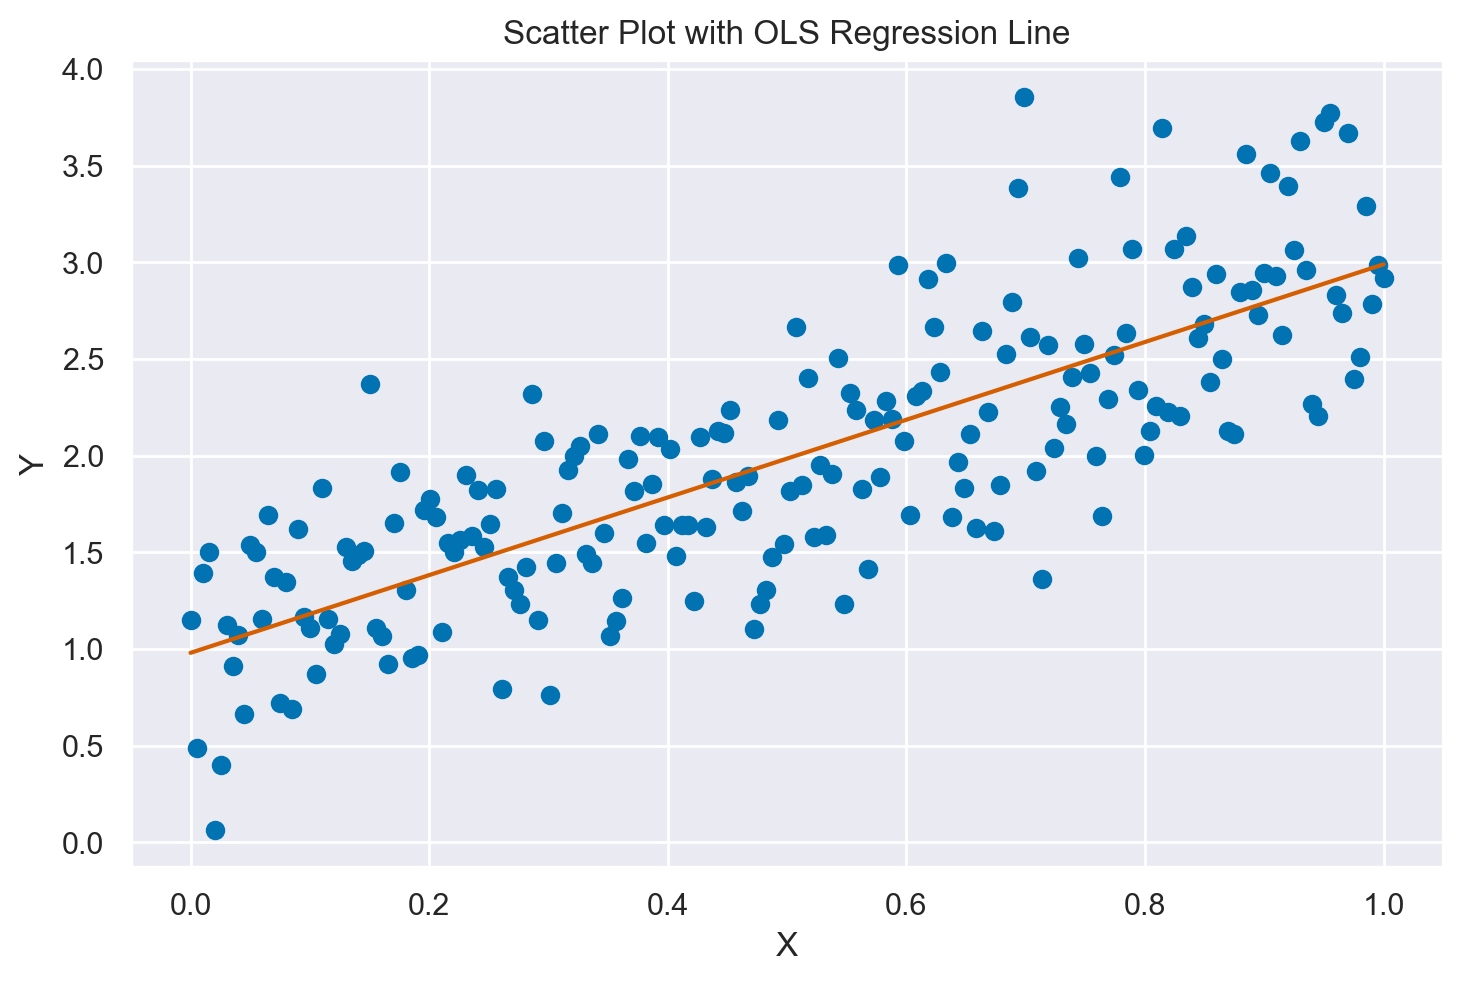

In [4]:
# Creating a scatter plot
plt.scatter(x, y)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot with OLS Regression Line")

# Fitting a linear regression
linear_regression = Polynomial.fit(data["x"], data["y"], 1)

# Plotting the regression line
plt.plot(data["x"], linear_regression(data["x"]), color="C3")
plt.show()

## Metodo basato su griglia

Il metodo basato su griglia è uno degli approcci più semplici per la stima Bayesiana dei parametri in un modello statistico, in questo caso, un modello di regressione lineare bivariato. Questo metodo è particolarmente utile quando il modello è semplice e la dimensionalità del problema è bassa, come nel nostro esempio con solo due parametri, $ \alpha $ e $ \beta $.

1. **Definizione della griglia**: Per ogni parametro che si desidera stimare ($ \alpha $ e $ \beta $ nel nostro caso), si definisce una griglia di valori possibili. Ad esempio, $ \alpha $ potrebbe variare da 0 a 3 e $ \beta $ da 0 a 3, entrambi con intervalli di 0.01.

2. **Calcolo della distribuzione a posteriori**: Per ogni combinazione di $ \alpha $ e $ \beta $ nella griglia, calcoliamo la probabilità a posteriori, che è proporzionale al prodotto della verosimiglianza e del prior.

$$
\text{Posteriore} = \text{Verosimiglianza} \times \text{Prior}
$$

Nel nostro esempio, la verosimiglianza è Gaussiana e il prior è anche Gaussiano. Usiamo i logaritmi per evitare problemi numerici.

3. **Normalizzazione**: Dopo aver calcolato il valore del posteriore per ogni punto nella griglia, normalizziamo questi valori in modo che la somma sia uguale a 1. Questo ci dà una distribuzione di probabilità discreta per $ \alpha $ e $ \beta $.

4. **Visualizzazione**: Spesso, il risultato è visualizzato come un grafico di contorno o una mappa di calore, che mostra le regioni di alta probabilità per le combinazioni di $ \alpha $ e $ \beta $.

5. **Stima dei Parametri**: La stima dei parametri può essere ottenuta come la media o la moda della distribuzione posteriore. Inoltre, possiamo calcolare intervalli di credibilità.

Nel codice seguente, implementiamo questo metodo calcolando il valore del log-posteriore per ogni combinazione di $ \alpha $ e $ \beta $ in una griglia definita. Poi usiamo un grafico di contorno per visualizzare la distribuzione posteriore dei parametri.

Nel caso presente, la normalizzazione è omessa per semplificare i calcoli.

Per effetturare i calcoli mediante il metodo basato su griglia dobbiamo definire alcune funzioni. Iniziamo con la log-verosimiglianza.

In [5]:
# Log-Gaussian likelihood 
def log_gaussian_likelihood(y, mu, sigma_squared):
    return stats.norm.logpdf(y, loc=mu, scale=np.sqrt(sigma_squared))

È inoltre necessario definire le distribuzioni a priori per i parametri non noti. Per il modello specifico in discussione, abbiamo assegnato ai coefficienti di regressione $\alpha$ e $\beta$ distribuzioni normali con una media di zero e una deviazione standard di 0.5. Questa assegnazione rappresenta una posizione relativamente non informativa riguardo ai parametri, fornendo un contesto circoscritto della loro distribuzione probabile.

In [6]:
# Log-Gaussian prior
def log_gaussian_prior(param, mean=0, variance=1):
    return stats.norm.logpdf(param, loc=mean, scale=np.sqrt(variance))

Il calcolo del logaritmo della probabilità a posteriori si esegue nel modo seguente.

In [7]:
# Log-Posterior calculation
def calc_log_posterior(a, b, y=y, x=x, sigma_squared=1.0):
    mu = a + b * x
    log_likelihood = log_gaussian_likelihood(y, mu, sigma_squared)
    log_prior_a = log_gaussian_prior(a)
    log_prior_b = log_gaussian_prior(b)
    return np.sum(log_likelihood) + log_prior_a + log_prior_b

Esaminiamo nei dettagli la funzione `calc_log_posterior`.

1. **`log_likelihood`**: Questo array contiene i logaritmi delle funzioni di verosimiglianza associate a ciascuna osservazione nel dataset. La funzione di verosimiglianza quantifica la capacità del modello di adattarsi ai dati osservati. Nel nostro caso, la verosimiglianza è modellata come una distribuzione Gaussiana con media $ \mu = a + b \cdot x $ e varianza $ \sigma^2 $.

2. **`np.sum(log_likelihood)`**: Operando nel dominio logaritmico, la somma dei logaritmi delle verosimiglianze è equivalente al prodotto delle verosimiglianze nel dominio originale. Questa somma aggrega la verosimiglianza globale del modello dati i parametri $ a $ e $ b $.

3. **`log_prior_a` e `log_prior_b`**: Si tratta dei logaritmi delle distribuzioni a priori per i parametri $ a $ e $ b $, rispettivamente. Questi prior esprimono le nostre credenze a priori riguardo la distribuzione dei parametri. In questo specifico caso, entrambi i prior sono modellati come distribuzioni Gaussiane.

4. **`log_prior_a + log_prior_b`**: La somma di questi due valori costituisce il logaritmo della probabilità a priori congiunta dei parametri $ a $ e $ b $.

5. **`np.sum(log_likelihood) + log_prior_a + log_prior_b`**: In questa fase, sommiamo il logaritmo della verosimiglianza complessiva al logaritmo del prior congiunto. Questa somma, nel dominio delle probabilità, equivale al prodotto della verosimiglianza e del prior, fornendo così la probabilità posteriore.

In sintesi, il valore restituito dalla funzione `calc_log_posterior` rappresenta il logaritmo della probabilità posteriore. Questo valore è proporzionale al prodotto $ \text{Verosimiglianza} \times \text{Prior} $, ed è calcolato in modo da garantire stabilità numerica.

Una volta definita la funzione `calc_log_posterior`, procediamo con l'applicazione del metodo di analisi basato su griglia. Questo metodo prevede l'identificazione di una griglia di valori potenziali per ciascun parametro che desideriamo stimare. In seguito, calcoliamo la probabilità posteriore per ogni punto della griglia, valutando così la distribuzione a posteriori associata a ciascuna combinazione di parametri.

1. **Definizione della griglia**: `X1` e `X2` rappresentano le griglie di valori per $ \alpha $ (l'intercetta) e $ \beta $ (la pendenza), rispettivamente. Qui, $ \alpha $ varia da 0 a 3 e $ \beta $ fa altrettanto. Entrambe le griglie sono divise in 100 parti uguali.

    ```python
    X1 = np.linspace(0, 3, 101)  # alpha (intercept)
    X2 = np.linspace(0, 3, 100)  # beta (slope)
    ```

2. **Inizializzazione**: `log_pp` è una matrice che conterrà il logaritmo della probabilità posteriore per ogni combinazione di $ \alpha $ e $ \beta $.

    ```python
    log_pp = np.zeros((101, 100))
    ```

3. **Calcolo del posteriore**: Il doppio ciclo for esamina ogni possibile combinazione di $ \alpha $ e $ \beta $ e calcola il logaritmo della probabilità posteriore utilizzando la funzione `calc_log_posterior`.

    ```python
    for x1 in X1:
        for x2 in X2:
            log_pp[k, j] = calc_log_posterior(x1, x2)
    ```

In [8]:
# Brute-force grid search for posterior visualization
X1 = np.linspace(0, 3, 101)  # alpha (intercept)
X2 = np.linspace(0, 3, 100)  # beta (slope)
log_pp = np.zeros((101, 100))

k = 0
for x1 in X1:
    j = 0
    for x2 in X2:
        log_pp[k, j] = calc_log_posterior(x1, x2)
        j += 1
    k += 1

Ora convertiamo il log-posteriore nella distribuzione a posteriori. Poiché abbiamo utilizzato i logaritmi per evitare problemi numerici, è necessario eseguire l'operazione inversa, ossia l'esponenziazione, per ottenere i valori originali della distribuzione posteriore.

Sottrarre il valore massimo da `log_pp` prima di procedere all'esponenziazione è una pratica comune per migliorare la stabilità numerica. Questo passaggio è importante perché l'esponenziazione di numeri molto grandi può causare un overflow. Sottraendo il valore massimo, garantiamo che il valore massimo nell'argomento di `np.exp()` sia zero, rendendo così l'operazione numericamente più stabile.

In [9]:
# To visualize in the original scale, we can exponentiate log_pp
pp = np.exp(log_pp - np.max(log_pp))  # Subtract the max for numerical stability

Produciamo quindi una mappa termica a contorno per visualizzare la distribuzione a posteriori dei parametri.

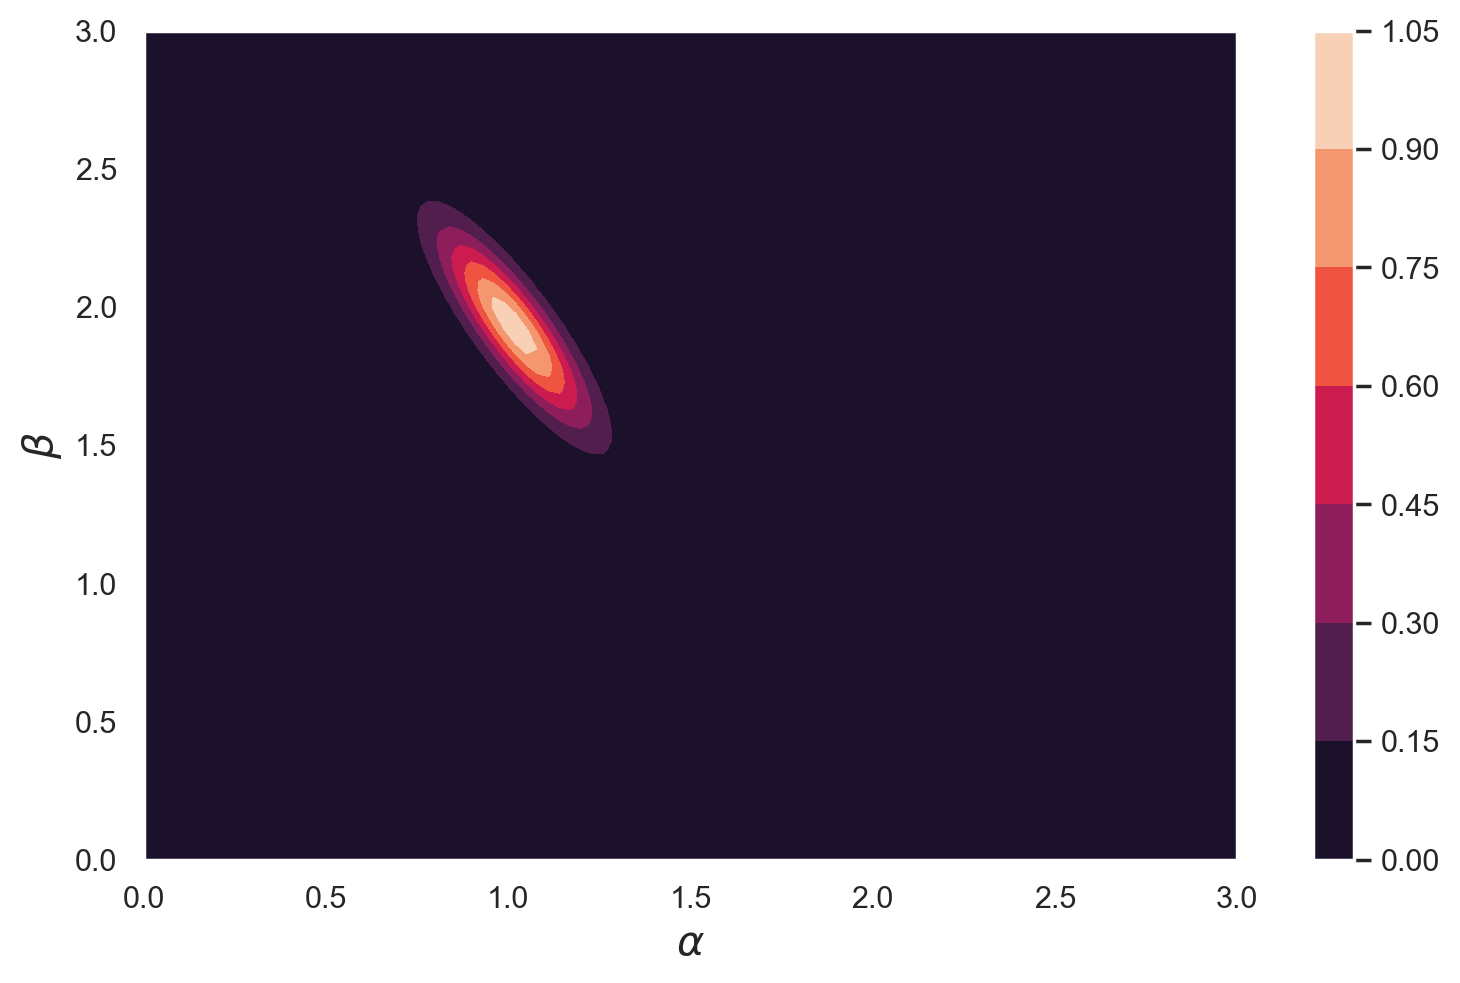

In [10]:
plt.contourf(X1, X2, pp.T)
plt.xlabel("$\\alpha$", size=15)
plt.ylabel("$\\beta$", size=15)
plt.colorbar()
plt.show()

Si osservi che le distribuzioni a posteriori dei parametri coincidono con i "valori reali" impiegati nella fase di simulazione.

## Campionamento con PyMC

Il secondo approccio che adotteremo per stimare le distribuzioni a posteriori dei parametri $ \alpha $ e $ \beta $ si basa sul campionamento MCMC, effettuato attraverso PyMC.

## Specificazione del modello

Definiamo il modello di regressione lineare bayesiano mediante la sintassi di PyMC. 

In [11]:
with Model() as model:
    # Define priors
    alpha = pm.Normal("alpha", sigma=1)
    beta = pm.Normal("beta", sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=5)
    # Define likelihood
    pm.Normal("y_obs", mu=alpha + beta * x, sigma=sigma, observed=y)

Effettuiamo il campionamento MCMC.

In [12]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time = 0:00:01.805349


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:02<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:02<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:02<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:02<?, ?it/s]

Running chain 0: 100%|█████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 839.73it/s]


Running chain 1: 100%|█████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 841.25it/s]


Running chain 2: 100%|█████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 842.33it/s]


Running chain 3: 100%|█████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 843.57it/s]


Sampling time = 0:00:02.937473


Transforming variables...


Transformation time = 0:00:00.116475


L'istruzione `pm.sampling_jax.sample_numpyro_nuts` restituisce un oggetto `InferenceData` che contiene i campioni raccolti dalle catene parallele generate dall'algoritmo di campionamento, insieme ad altri attributi. Il numero di catene parallele generate dipende dal numero di core di calcolo disponibili sulla macchina.

Diamo una rapida occhiata al modello che abbiamo appena stimato utilizzando il metodo `model_to_graphviz`.

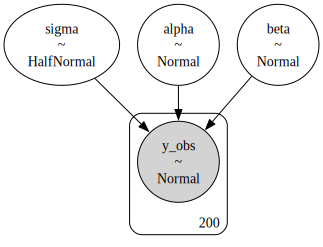

In [13]:
pm.model_to_graphviz(model)

Nel processo di costruzione del modello, abbiamo stabilito alcune ipotesi. La prima ipotesi afferma che, condizionatamente a $X$, i dati $y$ sono indipendenti; la seconda afferma che il valore atteso di $Y$ è una funzione lineare di $X$; la terza ipotesi stabilisce che, condizionatamente a $X_i$, la variabile $Y$ si distribuisce normalmente attorno al suo valore atteso con una deviazione standard $\sigma$, la quale risulta essere costante per $i \in 1, ..., n$. Queste tre ipotesi costituiscono il fondamento della regressione lineare gaussiana. 

## Interpretare i risultati della regressione bayesiana

Esaminiamo ora più da vicino l'oggetto di classe `arviz.InferenceData` restituito dalla funzione `pm.sample()` di PyMC. L'oggetto `xarray` restituito dalla funzione `pm.sample()` è una struttura dati multidimensionale che contiene le tracce (ossia le sequenze di campioni) generate dall'algoritmo di campionamento MCMC per ciascun parametro del modello bayesiano.

In [14]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Ecco una panoramica di alcune delle sue principali componenti.

- **Dimensioni** (Dims): Le dimensioni rappresentano gli assi lungo i quali i dati sono organizzati. Ad esempio, le dimensioni `chain` e `draw` rappresentano rispettivamente le diverse catene di MCMC e i singoli campioni all'interno di ciascuna catena.
  
- **Coordinate** (Coords): Le coordinate sono array di etichette che identificano i punti univocamente lungo una dimensione. Ad esempio, se ci sono 4 catene di MCMC, ciascuna con 1000 campioni, le coordinate per la dimensione `chain` saranno `[0, 1, 2, 3]` e per `draw` avremo `[0, 1, ..., 999]`.
  
- **Variabili** (Data Variables): Le variabili contengono gli effettivi campioni per ciascun parametro del modello. Ogni variabile ha associate dimensioni e coordinate che aiutano a interpretare i dati contenuti. Ad esempio, se il modello ha un parametro `alpha`, troverete una variabile `alpha` nell'oggetto `xarray` che contiene tutti i campioni di `alpha` organizzati secondo le dimensioni e le coordinate specificate.
  
- **Attributi** (Attrs): Gli attributi sono metadati che possono includere ulteriori dettagli come il nome del modello, il metodo di campionamento utilizzato, ecc.

Consideriamo ora il caso specifico in esame.

### `posterior`

#### Dimensioni:
- `chain: 4`: Indica che ci sono 4 catene di MCMC.
- `draw: 1000`: Indica che ci sono 1000 campioni per ogni catena.

#### Coordinate:
- `chain (chain) int64 0 1 2 3`: Etichette per le 4 catene.
- `draw (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999`: Etichette per i 1000 campioni.

#### Variabili dati:
- `alpha (chain, draw) float64 ...`: Campioni per il parametro `alpha`, disposti su 4 catene e 1000 campioni ciascuna.
- `beta (chain, draw) float64 ...`: Campioni per il parametro `beta`.
- `sigma (chain, draw) float64 ...`: Campioni per il parametro `sigma`.

#### Attributi:
- `created_at`: Data e ora di creazione del dataset.
- `arviz_version`: Versione di ArviZ usata.

### `sample_stats`

Questo è simile al `posterior`, ma contiene statistiche sul campionamento piuttosto che sui parametri del modello.

#### Variabili dati:
- `acceptance_rate`: Tasso di accettazione per ogni passaggio di campionamento.
- `step_size`: Dimensione del passo usato nell'algoritmo di campionamento.
- `diverging`: Indica se un campione è divergente o meno.
- `energy`: Energia associata al campione.
- `n_steps`: Numero di passaggi effettuati per ottenere il campione.
- `tree_depth`: Profondità dell'albero utilizzato nell'algoritmo di campionamento (ad esempio, NUTS).
- `lp`: Log probabilità del campione.

### `observed_data`

Contiene i dati osservati su cui è stato addestrato il modello bayesiano.

#### Dimensioni:
- `y_obs_dim_0: 200`: Indica che ci sono 200 osservazioni per la variabile `y_obs`.

#### Coordinate:
- `y_obs_dim_0 (y_obs_dim_0) int64 0 1 2 3 4 5 ... 195 196 197 198 199`: Etichette per le 200 osservazioni.

#### Variabili dati:
- `y_obs (y_obs_dim_0) float64 ...`: I dati osservati per la variabile `y_obs`.

#### Attributi:
- `created_at`: Data e ora di creazione del dataset.
- `arviz_version`: Versione di ArviZ usata.
- `inference_library`: Libreria di inferenza utilizzata (in questo caso, numpyro).
- `inference_library_version`: Versione della libreria di inferenza.
- `sampling_time`: Tempo impiegato per il campionamento.

In sintesi, l'oggetto `InferenceData` è una struttura dati che rende più semplice la manipolazione e l'analisi dei risultati del campionamento MCMC in un contesto bayesiano.

Nel caso presente abbiamo dunque 4 catene, ciascuna formata da 1000 elementi, per ciascuno dei tre parametri ($\alpha$, $\beta$, $\sigma$)

Gli attributi dell'oggetto `InferenceData` possono essere esaminati come un `dict` di `numpy.arrays`. Ad esempio, consideriamo il parametro `alpha`. I campioni a posteriori sono contenuti in un array 4x3000, laddove la prima dimensione indicizza le catene e la seconda le iterazioni.

In [15]:
idata.posterior["alpha"].shape

(4, 1000)

Per vedere i primi 5 valori della variabile `alpha` nella prima catena (indicizzata con 0), usiamo il seguente codice:

In [16]:
idata.posterior["alpha"][0, 0:5]

<xarray.DataArray 'alpha' (draw: 5)>
array([0.99245104, 0.90538011, 1.0681243 , 1.08181856, 1.04839542])
Coordinates:
    chain    int64 0
  * draw     (draw) int64 0 1 2 3 4

In manera analoga, per la seconda catena abbiamo:

In [17]:
idata.posterior["alpha"][1, 0:5]

<xarray.DataArray 'alpha' (draw: 5)>
array([1.01000278, 1.0027748 , 0.98163607, 0.88292394, 0.93076874])
Coordinates:
    chain    int64 1
  * draw     (draw) int64 0 1 2 3 4

In maniera simile possiamo recuperare i campioni a posteriori del parametro $\beta$.

In [18]:
idata.posterior["beta"].shape

(4, 1000)

Nel modello di regressione, i valori predetti sono dati da $\hat{y}_i = \alpha + \beta x_i$, dove $\alpha$ è l'intercetta, $\beta$ è la pendenza, e $x$ è la variabile indipendente o predittore. Se avessimo una singola stima per i parametri $\alpha$ e $\beta$, calcolare $\hat{y}$ sarebbe un compito semplice.

Nel presente contesto, però, "alpha" e "beta" sono array multidimensionali che rappresentano più stime o campioni dalla distribuzione a priori. Nell'esempio presente, la stima a posteriori di $\alpha$ ha una dimensione di $4 \times 1000$, e lo stesso vale per $\beta$. Di conseguenza, non stiamo lavorando con degli scalari, ma con distribuzioni di probabilità per questi parametri. 

Il predittore $x$ è un vettore costituito da 200 elementi. 

In [19]:
data["x"].shape

(200,)

In [20]:
print(*data.x[0:5])

0.0 0.005025125628140704 0.010050251256281407 0.01507537688442211 0.020100502512562814


I dati $y$ sono

In [21]:
print(*y[0:5])

1.1523585398772156 0.4900581981360337 1.3953261004157915 1.5004331119644512 0.06468341069820738


ovvero

In [22]:
print(idata.observed_data.y_obs[0:5].values)

[1.15235854 0.4900582  1.3953261  1.50043311 0.06468341]


Possiamo calcolare la media della distribuzione a posteriori di `alpha` nel modo seguente.

In [23]:
idata.posterior["alpha"].mean().item()

0.9875587826767943

Si noti che `idata.posterior["alpha"].mean()` produce un array NumPy di forma `(1,)`. Il metodo `.item()` è usato per estrarre il valore scalare contenuto nell'array. 

Facciamo lo stesso per la media a posteriori di `beta`:

In [24]:
idata.posterior["beta"].mean().item()

1.9920378796086602

Possiamo dunque usare la sintassi `plt.plot(data.x, idata.posterior["alpha"].mean().item() + idata.posterior["beta"].mean().item() * (data.x))` per disegnare la retta di regressione calcolata con la media a posteriori dei paraemtri $\alpha$ e $\beta$.

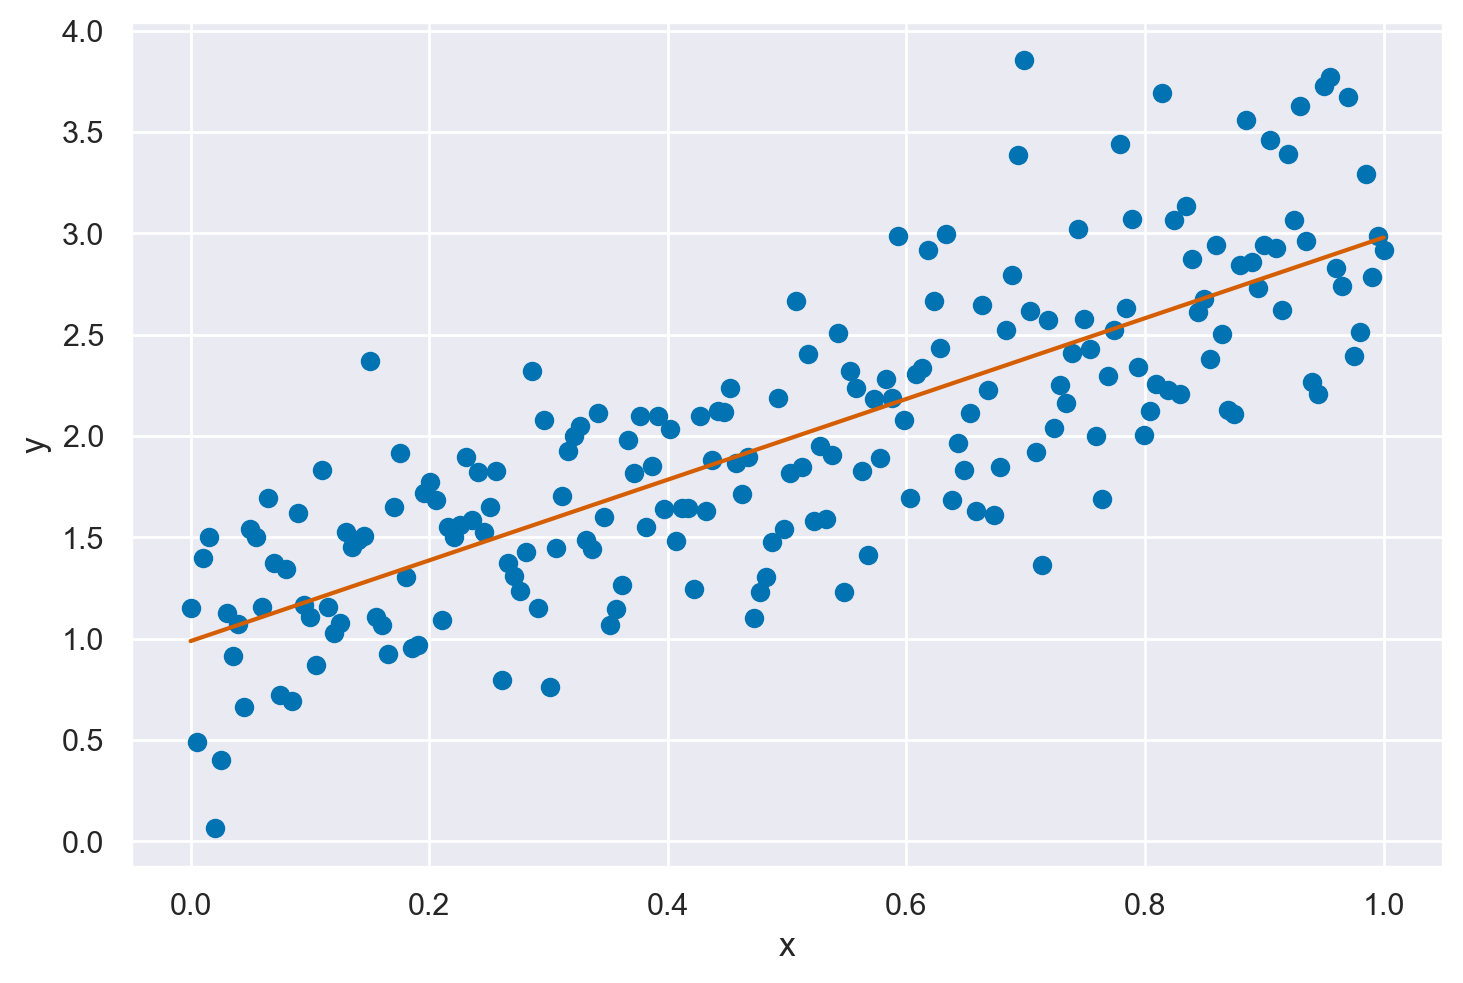

In [25]:
plt.plot(x, y, "C0o")
plt.plot(
    x,
    idata.posterior["alpha"].mean().item()
    + idata.posterior["beta"].mean().item() * x,
    "C3"
)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Tuttavia, è necessario considerare le distribuzioni a posteriori dei parametri invece di singoli valori. Ciò introduce una complessità aggiuntiva, poiché richiede una gestione accurata delle dimensioni dei dati. Fortunatamente, con l'uso del pacchetto xarray, non abbiamo bisogno di preoccuparci di allineare manualmente questi array di dimensioni diverse. Utilizzando `xr.DataArray(data["x"])`, possiamo far fronte a questa complessità, lasciando che il pacchetto gestisca l'allineamento per noi.

In seguito, possiamo salvare i valori predetti $\hat{y}$, che etichettiamo come `y_model`, all'interno dell'oggetto `idata`. Questo passaggio ci facilita nell'analisi successiva, poiché tutti i dati relativi al modello saranno contenuti in un unico oggetto strutturato.

In [26]:
idata.posterior["y_model"] = idata.posterior["alpha"] + idata.posterior[
    "beta"
] * xr.DataArray(x)
idata.posterior["y_model"].shape

(4, 1000, 200)

Dopo aver organizzato le dimensioni dei dati attraverso il pacchetto xarray, possiamo passare alla visualizzazione grafica dell'incertezza associata ai parametri della retta di regressione nel contesto bayesiano. Il seguente codice permette di generare un grafico in cui vengono sovrapposte 100 rette di regressione ai dati puntuali nel diagramma a dispersione. Ognuna di queste rette è calcolata utilizzando un insieme di valori per i parametri $\alpha$ e $\beta$, selezionati casualmente dalle loro rispettive distribuzioni a posteriori. Questa visualizzazione offre una panoramica intuitiva sia delle stime dei parametri che del grado di incertezza associato a ciascuna, come derivato dall'analisi bayesiana.

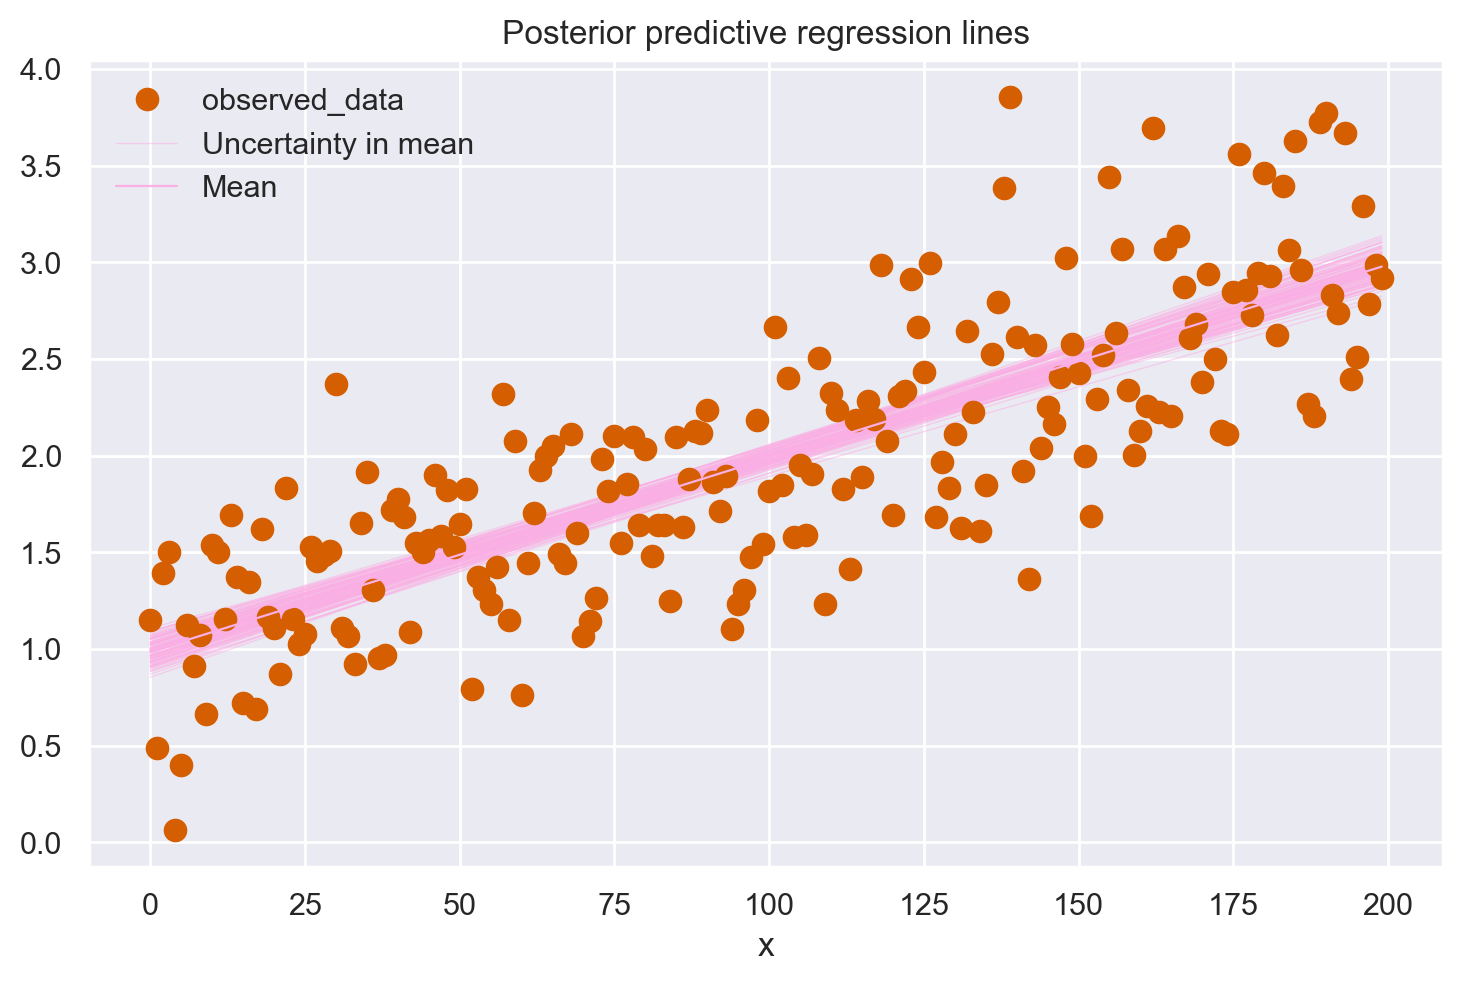

In [27]:
az.plot_lm(idata=idata, y=y, num_samples=100, y_model="y_model")
plt.title("Posterior predictive regression lines")
plt.xlabel("x");

Questo insieme di rette di regressione a posteriori evidenzia chiaramente l'incertezza nella nostra stima della vera retta di regressione. Nel caso specifico, l'incertezza è molto ridotta.

```{note}
Si osservi che ArviZ modifica la scala sull'asse delle ascisse. Generalmente, `az.plot_lm()` si aspetta che l'`InferenceData` fornito come input contenga tutte le informazioni necessarie per generare il plot, incluse i predittori. Se i dati originali ("x" in questo caso) non sono inclusi nell'`InferenceData`, la funzione utilizza gli indici come fallback.
```

Dirigiamo ora la nostra attenzione sulla distribuzione a posteriori dei parametri del modello. Utilizzando le funzioni disponibili nel modulo `Arviz`, possiamo visualizzare graficamente la distribuzione a posteriori dei parametri, generare i cosiddetti trace plot, e ottenere un riassunto numerico delle nostre stime.

Il trace plot è un tipo di grafico specifico che rappresenta l'evoluzione della catena di Markov per ogni parametro, visualizzando ciascuna catena parallela. È possibile creare un trace plot usando la funzione `plot_trace`. Questo grafico è un potente strumento per valutare diversi aspetti della convergenza della catena:

- **Valore stazionario**: Permette di osservare se la catena converge a un valore stazionario, che è un indicatore della sua stabilità.
- **Indipendenza delle catene**: Il grafico aiuta a verificare se le catene sono indipendenti l'una dall'altra, un requisito importante per l'efficacia dell'analisi.
- **Esplorazione dello spazio dei parametri**: Si può valutare se la catena esplora adeguatamente lo spazio dei parametri, equilibrando la scoperta di nuove regioni con l'esplorazione approfondita delle regioni già identificate.
- **Presenza di autocorrelazione**: Il plot permette di rilevare l'eventuale autocorrelazione tra le iterazioni consecutive della catena, che potrebbe indicare una convergenza lenta o non ottimale.

In sintesi, il trace plot è una rappresentazione visiva fondamentale che fornisce intuizioni preziose sulla qualità e l'affidabilità delle stime dei parametri in un'analisi bayesiana.

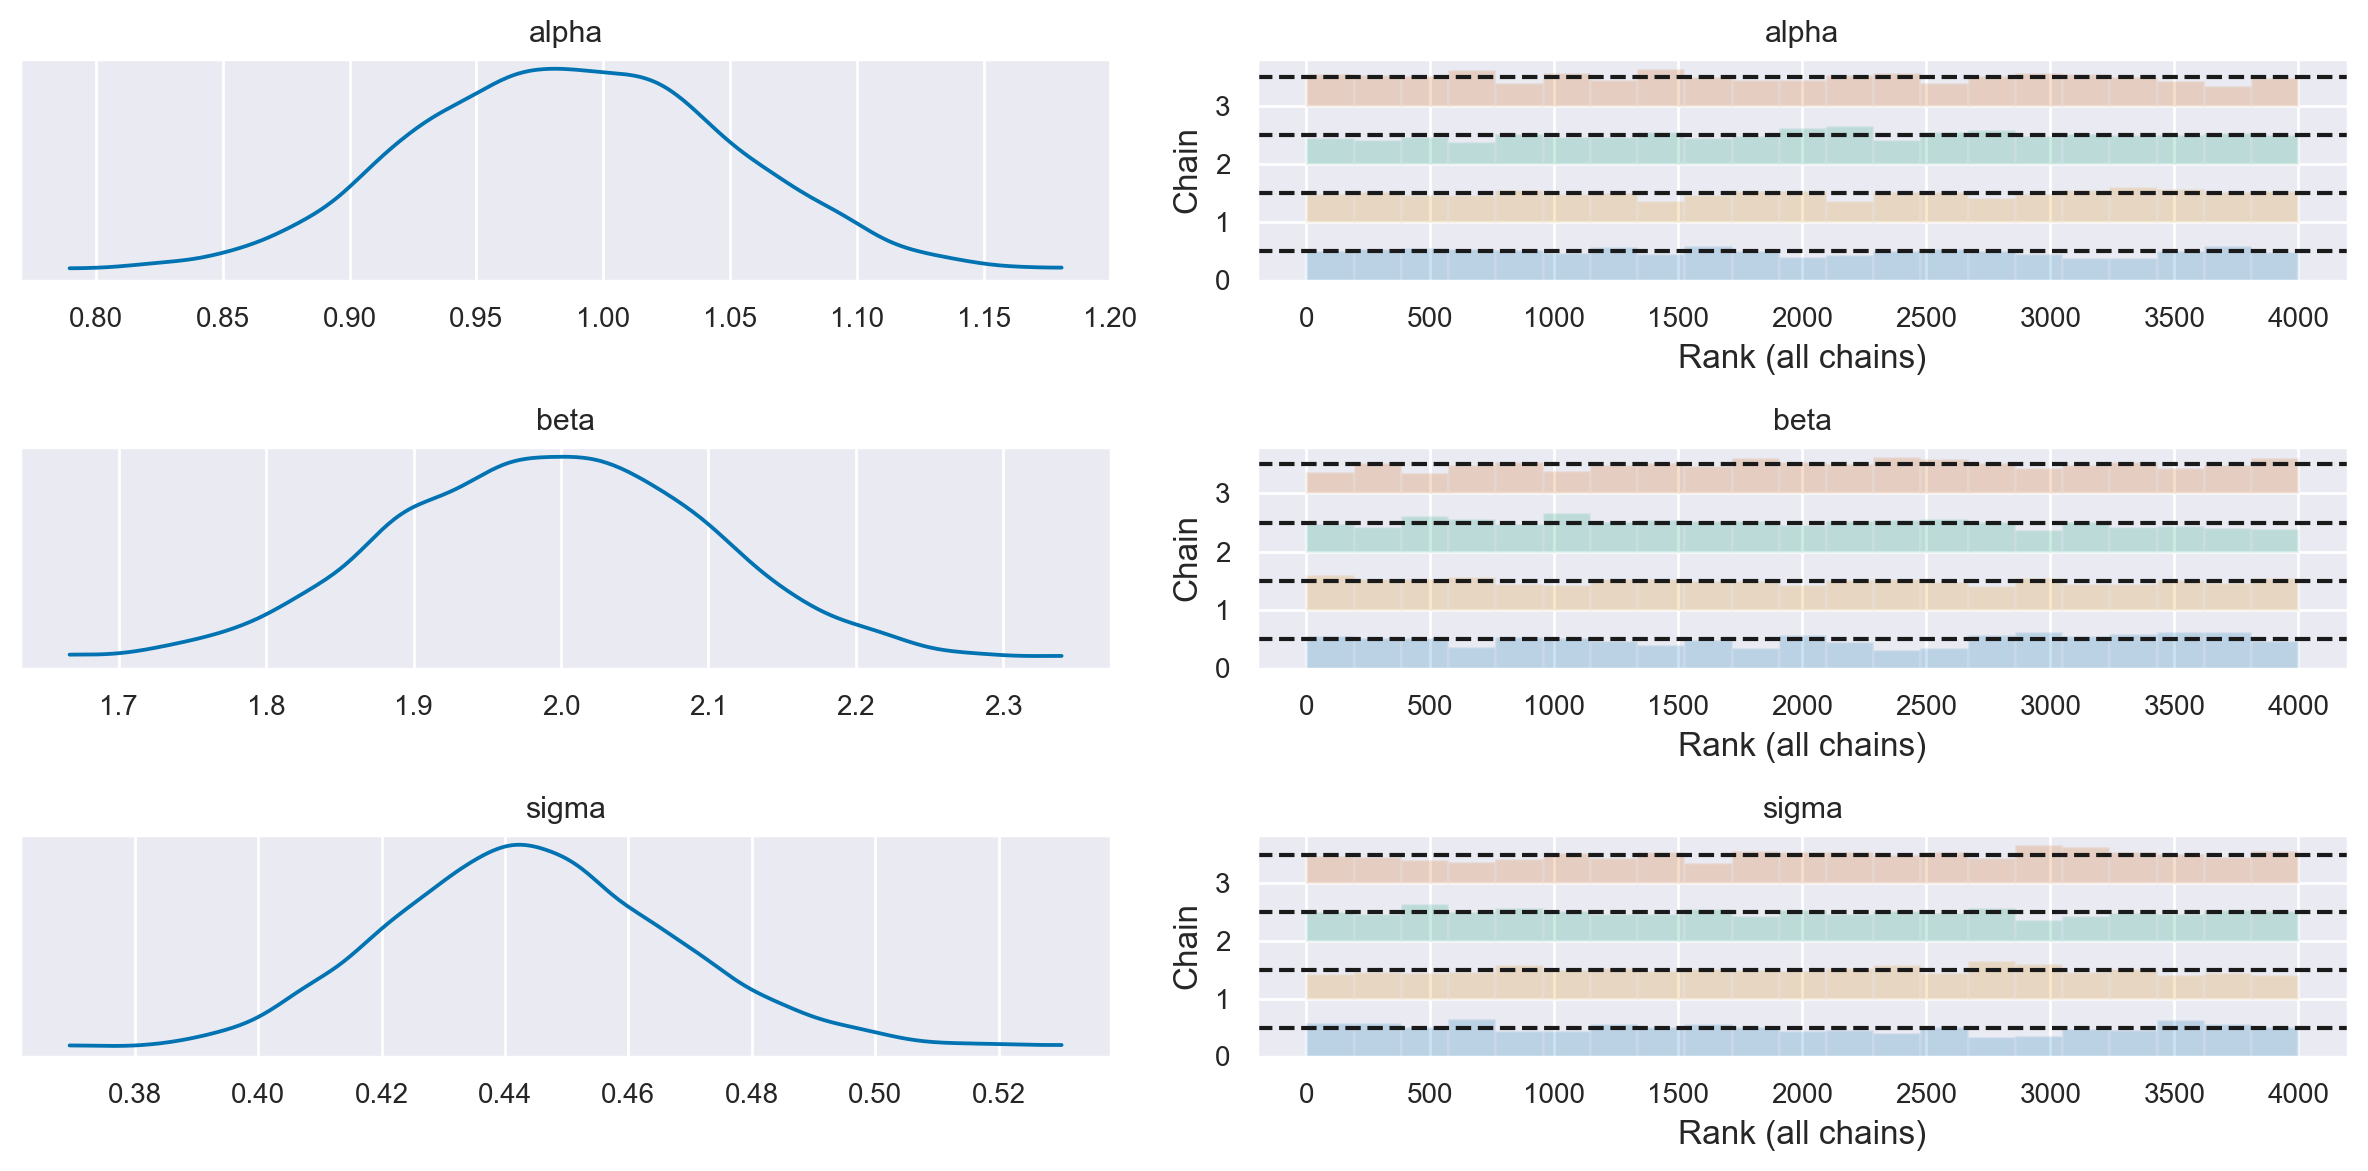

In [28]:
var_names = ["alpha", "beta", "sigma"]
az.plot_trace(idata, var_names=var_names, combined=True, kind="rank_bars")
plt.tight_layout()
plt.show()

La funzione `summary` ci fornisce un riepilogo delle stime dei parametri, compresi la media, la deviazione standard, la mediana, i valori minimi e massimi e altri valori percentili della distribuzione a posteriori. Questi risultati possono essere utilizzati per fare inferenza sui parametri e per confrontarli con i loro valori "veri" utilizzati per generare i dati. Di default, fonisce un intervallo di credibilità al 94%.

In [29]:
params = ["alpha", "beta", "sigma"]
az.summary(idata, var_names = params, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.99,0.06,0.88,1.10,0.0,0.0,1662.58,1894.91,1.0
beta,1.99,0.11,1.78,2.19,0.0,0.0,1763.68,2066.81,1.0
sigma,0.44,0.02,0.40,0.49,0.0,0.0,2310.69,2262.48,1.0


Analizzando il sommario numerico presentato in precedenza, possiamo dedurre che il modello è stato efficace nell'ottenere stime dei parametri che corrispondono strettamente ai valori reali utilizzati nel meccanismo di generazione dei dati.

Nel contesto dell'inferenza bayesiana, le stime dei parametri non sono solo precise ma anche intuitivamente interpretabili. Prendiamo, ad esempio, il parametro $\beta$: la media della distribuzione a posteriori è 2.01, con una deviazione standard di 0.11, e l'intervallo di credibilità del 94% si estende da 1.81 a 2.20. Questo intervallo, conosciuto come l'intervallo di densità più alta (HDI), rappresenta la gamma entro la quale i valori sono più densamente concentrati nella distribuzione a posteriori. La sua ampiezza può essere personalizzata utilizzando l'argomento `hdi_prob=`.

Questi risultati ci consentono di affermare con fiducia che la stima di $\beta$ ottenuta è molto vicina al valore effettivamente utilizzato per simulare il parametro $\beta$, confermando così l'accuratezza del nostro modello nella rappresentazione dei dati sottostanti.

In [30]:
idata.posterior['alpha']

<xarray.DataArray 'alpha' (chain: 4, draw: 1000)>
array([[0.99245104, 0.90538011, 1.0681243 , ..., 1.06480954, 1.09724343,
        1.0597603 ],
       [1.01000278, 1.0027748 , 0.98163607, ..., 0.90842741, 1.07021385,
        1.05684727],
       [0.92038389, 0.98586621, 1.02880096, ..., 0.92852697, 0.93309102,
        0.9664161 ],
       [0.91858236, 0.96283059, 1.01616946, ..., 0.87007544, 0.89232037,
        0.94462154]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

Vogliamo creare ora un grafico di contorno per visualizzare la distribuzione a posteriori dei parametri, così come abbiamo fatto sopra con il metodo basato su griglia. 

Ci sono 4 catene e 1000 campioni in ciascuna catena sia per $ \alpha $ che per $ \beta $, risultando in un array 2D per ciascun parametro.

In [31]:
alpha_array = idata.posterior['alpha'].values
beta_array = idata.posterior['beta'].values

print("Shape of alpha_array:", alpha_array.shape)
print("Shape of beta_array:", beta_array.shape) 

Shape of alpha_array: (4, 1000)
Shape of beta_array: (4, 1000)


È dunque necessario appiattire questi array 2D in array 1D per poterli tracciare utilizzando `sns.kdeplot`. Per fare questo è possibile utilizzare la funzione `ravel()` di NumPy. Questo concatenerà gli array lungo ciascuna catena, producendo un singolo array 1D con 4000 punti dati sia per $ \alpha $ che per $ \beta $.

In [32]:
# Flatten the 2D arrays into 1D arrays
alpha_flat = alpha_array.ravel()
beta_flat = beta_array.ravel()

Possiamo ora usare `kdeplot`.

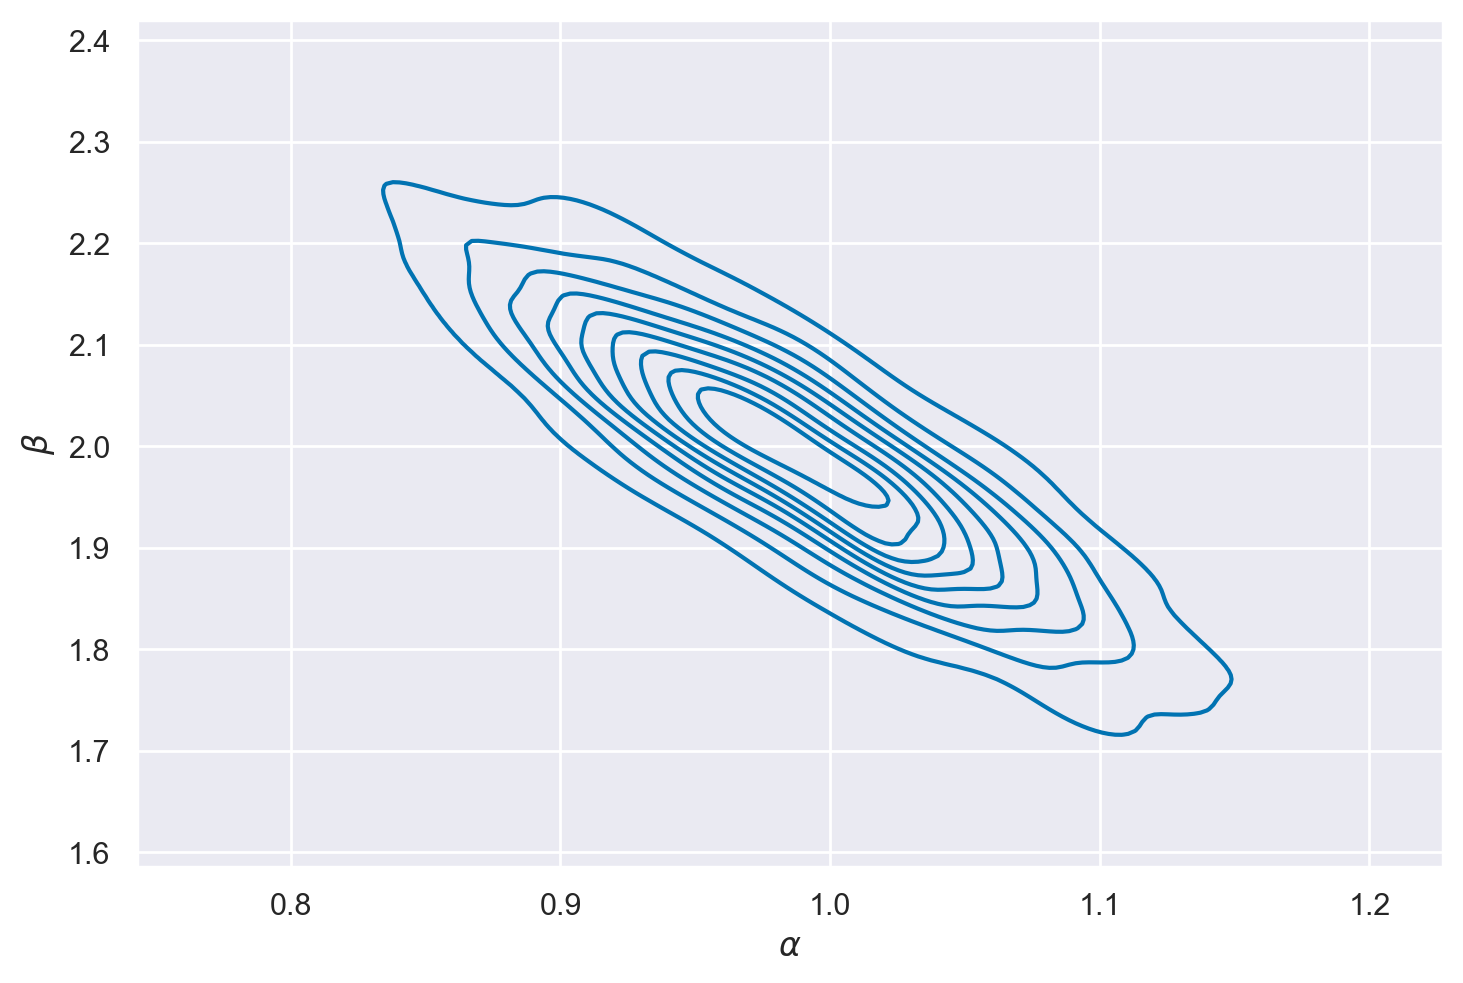

In [33]:
# Create the KDE plot
sns.kdeplot(x=alpha_flat, y=beta_flat)
plt.xlabel("$\\alpha$")
plt.ylabel("$\\beta$")
plt.show()

## Distribuzione predittiva a priori

Valutiamo ora l'adeguatezza delle distribuzioni a priori per i parametri del modello. Per fare ciò, utilizziamo la funzione `pm.sample_prior_predictive` per campionare i dati generati dal modello specificato, tenendo conto solo delle distribuzioni a priori e ignorando i dati effettivi. 

In [34]:
with model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [alpha, beta, sigma, y_obs]


Per semplicità, assegniamo il nome `prior` ai dati proditti da PyMC.

In [35]:
prior = prior_samples.prior
prior

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 100)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
Data variables:
    sigma    (chain, draw) float64 3.196 4.06 7.225 14.08 ... 6.004 0.8634 4.131
    alpha    (chain, draw) float64 0.6927 -3.167 -1.209 ... -0.5118 -0.6311
    beta     (chain, draw) float64 0.7398 -0.8997 -1.736 ... -1.483 -1.676
Attributes:
    created_at:                 2024-01-26T21:44:53.388443
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.3

Creiamo un vettore `x` che riproduce il campo di variazione dei valori `x` osservati.

In [36]:
x = xr.DataArray(np.linspace(0, 1, 50))
x

<xarray.DataArray (dim_0: 50)>
array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])
Dimensions without coordinates: dim_0

Generiamo ora un grafico che visualizza 50 rette, ognuna definita da un valore `alpha` e un valore `beta` selezionati casualmente dalle distribuzioni a priori specificate dal modello. È importante sottolineare che la retta dei minimi quadrati mostrata nel precedente grafico di dispersione rientra tra le possibili rette generate dalle distribuzioni a priori. Inoltre, le pendenze delle rette generate non saranno eccessivamente estreme rispetto alla pendenza dei minimi quadrati indicata nel grafico precedente che riporta il diagramma a dispersione dei dati. Questo risultato conferma la validità delle distribuzioni a priori scelte.

L'instruzione seguente recupera 50 valori dalla distribuzione a priori di `alpha`.

In [37]:
np.array(az.extract_dataset(prior_samples["prior"])["alpha"][:50])

array([ 0.69271676, -3.16739889, -1.20944216,  0.41798025,  0.74096191,
        0.04985597, -1.48926107, -0.80733478,  0.5130205 , -0.49065984,
        1.18892809, -0.24589182,  1.42790536,  0.0921957 , -1.13890419,
        0.95611762, -0.14505107, -0.99481762,  0.64018974,  1.27965493,
        1.06658582, -1.174519  , -1.37929645,  0.8090809 , -0.16941669,
        0.33579439, -0.3962362 , -0.56844334, -1.85906695, -0.73195534,
        0.55861714, -1.19231739,  0.6183217 , -0.34396042, -1.09130114,
       -1.77990949, -0.67823796, -1.54218788,  2.66789215, -0.05915444,
        1.76557479, -0.99997952, -0.39338442,  1.2561419 ,  1.22832592,
       -0.37268753, -0.13894555,  0.08967138,  0.87666335,  0.75358391])

L'instruzione seguente recupera 50 valori dalla distribuzione a priori di `beta`.

In [38]:
np.array(az.extract_dataset(prior_samples["prior"])["beta"][:50])

array([ 0.73980456, -0.89965699, -1.7361734 ,  0.53984847,  0.3246997 ,
       -1.35966235,  0.39384689, -1.44614235,  2.42144399, -0.46026619,
        0.42731655, -2.45457904, -0.19145825, -1.24824555,  0.04854281,
        2.34663869, -1.94107461, -1.18813342,  1.57946823,  0.01960725,
        1.10620746, -0.9998698 , -0.19328285,  1.12720855,  0.53029717,
        0.55156857,  0.00791218,  0.09377023,  0.14502989,  0.39166713,
        1.77400317,  0.51446748, -0.31461079, -1.14417552, -0.8577334 ,
       -0.40994029, -0.49180475, -0.02143921, -0.54647557,  0.4806817 ,
        0.07415238, -0.61929102,  0.44566934, -0.13645921,  1.28287621,
        0.07824837,  0.18520897,  0.88350404, -0.46289835,  0.00334583])

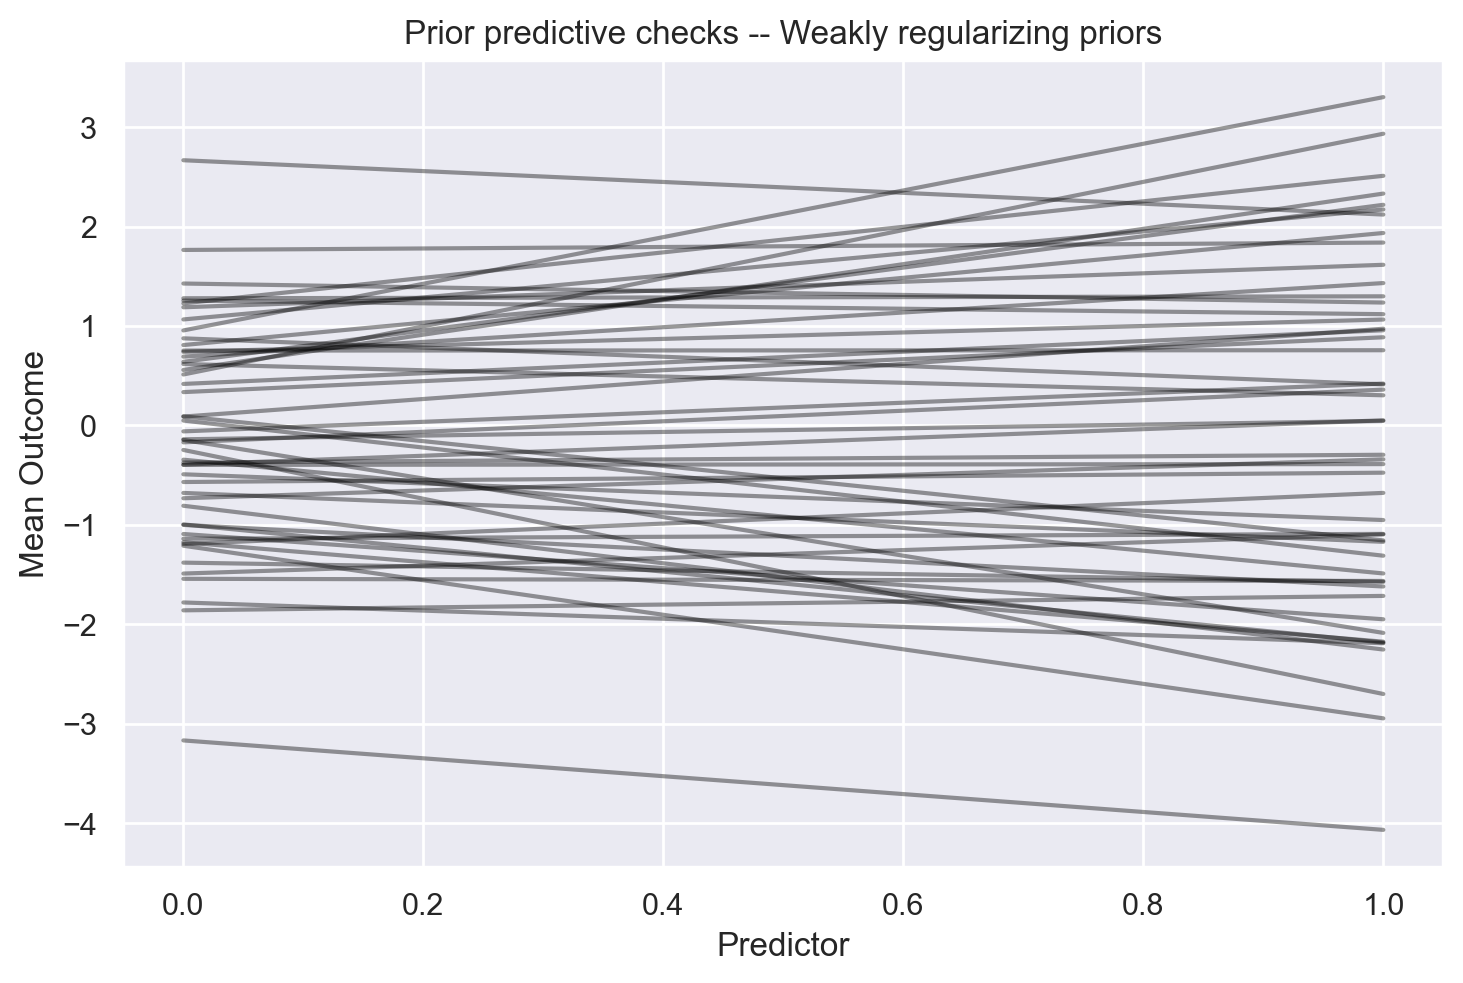

In [39]:
prior_samp_alpha = np.array(az.extract_dataset(prior_samples["prior"])["alpha"][:50])
prior_samp_beta = np.array(az.extract_dataset(prior_samples["prior"])["beta"][:50])

# Plotting the prior samples
for alpha, beta in zip(prior_samp_alpha, prior_samp_beta):
    y = alpha + beta * x
    plt.plot(x, y, c="black", alpha=0.4)

# Setting labels and title
plt.xlabel("Predictor")
plt.ylabel("Mean Outcome")
plt.title("Prior predictive checks -- Weakly regularizing priors")
plt.show()

In sintesi, le istruzioni precedenti calcolano e tracciano un insieme di rette di regressione lineare in base a stime a priori per i parametri `alpha` e `beta`. Le linee tracciate rappresentano diverse realizzazioni possibili del modello, in accordo con l'incertezza espressa nelle distribuzioni a priori.

## Distribuzione predittiva a posteriori

Una volta stimata la distribuzione a posteriori, è possibile utilizzarla per generare la distribuzione predittiva a posteriori. Questa distribuzione rappresenta le previsioni del modello, tenendo conto dell'incertezza sui parametri. Per fare ciò, si generano $M$ campioni $\{x, \hat{y}\}$, dove la variabile $x$ corrisponde a quella del campione osservato. In ciascun campione, ogni valore $\hat{y}_i$ per $i=1,\dots,n$ viene generato casualmente dalla distribuzione normale $\mathcal{N}(\mu = \alpha + \beta \cdot x_i, \sigma)$, dove i valori dei parametri $\alpha$, $\beta$, e $\sigma$ sono estratti dalle rispettive distribuzioni a posteriori. Attraverso questo processo, la distribuzione predittiva a posteriori incorpora non solo la struttura del modello ma anche l'incertezza associata alla stima dei parametri, fornendo così una rappresentazione più completa e sfumata delle previsioni del modello.

In [40]:
with model:
    pm.sample_posterior_predictive(
        idata, extend_inferencedata=True, random_seed=rng);

Sampling: [y_obs]


Possiamo utilizzare la funzione `az.plot_ppc()` per eseguire un controllo predittivo a posteriori (*posterior predictive check*, PPC). Questo strumento grafico è fondamentale nell'analisi bayesiana per verificare la bontà dell'adattamento del modello ai dati osservati.

Il PPC consiste nel confrontare le distribuzioni predittive a posteriori con i dati effettivamente osservati. In pratica, si generano diverse repliche dei dati in base al modello e si confrontano con i dati reali per valutare in che misura il modello cattura la struttura sottostante ai dati.

Il grafico prodotto dalla funzione `az.plot_ppc()` mostra le distribuzioni predittive a posteriori per la variabile osservata $y$, sovrapponendo i dati effettivi. Questo permette di visualizzare chiaramente come le previsioni del modello si allineano con i dati osservati, evidenziando eventuali discrepanze.

Se il modello è ben adattato, le repliche simulate dovrebbero assomigliare ai dati osservati, e il grafico mostrerà una buona sovrapposizione tra le distribuzioni simulate e i dati reali. In caso contrario, eventuali discrepanze nel grafico possono suggerire aree in cui il modello potrebbe essere migliorato.

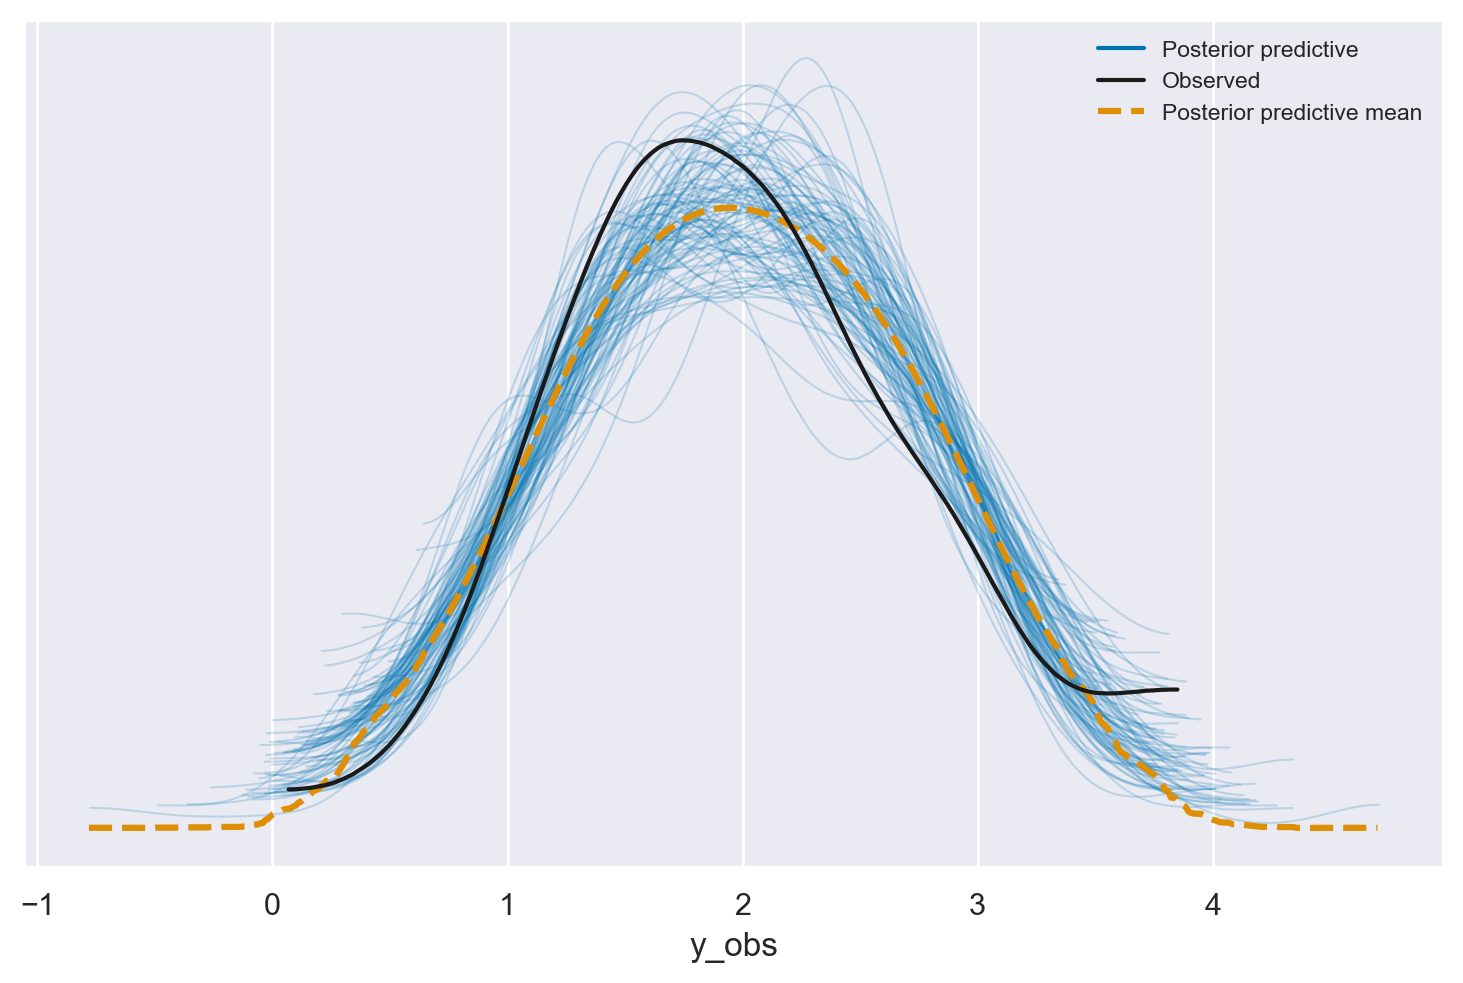

In [41]:
az.plot_ppc(idata, num_pp_samples=100)
plt.show()

Nel *posterior predictive check*, le linee blu rappresentano le stime della distribuzione predittiva a posteriori e la linea nera rappresenta i dati osservati. È possibile notare che le previsioni a posteriori ben corrispondono ai dati osservati in tutta la gamma dei valori della variabile dipendente, indicando che il modello è in grado di fornire previsioni accurate.

## Commenti e considerazioni finali

In questo capitolo abbiamo esaminato come stimare i parametri del modello di regressione bivariato tramite l'approccio bayesiano utilizzando sia PyMC. Abbiamo osservato come le distribuzioni predittive a priori siano utili per selezionare le distribuzioni a priori dei parametri $\alpha$ e $\beta$ del modello di regressione. Inoltre, abbiamo esaminato come la distribuzione predittiva a posteriori sia utile per valutare l'adattamento del modello ai dati osservati.

Per un confronto con un approccio alternativo, in appendice è fornita un'introduzione alla trattazione frequentista del modello di regressione lineare bivariato. Questa sezione aggiuntiva offre una panoramica degli aspetti chiave dell'approccio frequentista, permettendo così di confrontare e comprendere le differenze tra i due approcci nella stima dei parametri e nell'interpretazione dei risultati.

In [42]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Jan 26 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

numpy     : 1.26.2
scipy     : 1.11.4
pymc      : 5.10.3
pandas    : 2.1.4
matplotlib: 3.8.2
arviz     : 0.17.0
xarray    : 2023.12.0
seaborn   : 0.13.0

Watermark: 2.4.3

